#### Code based on the article: https://arxiv.org/abs/1903.10176

In [4]:
!git clone https://github.com/Huang-chao-yan/DeepRED.git

Cloning into 'DeepRED'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 33 (delta 5), reused 1 (delta 1), pack-reused 23 (from 1)
Receiving objects: 100% (33/33), 336.35 KiB | 8.01 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [6]:
%cd DeepRED

/content/DeepRED


# Import libs

In [10]:
import os
from threading import Thread  # needed since the denoiser is running in parallel
import queue

import numpy as np
import torch
import torch.optim
from models.skip import skip  # our network

from utils.utils import *  # auxiliary functions
from utils.blur_utils import *  # blur functions
from utils.data import Data  # class that holds img, psnr, time

from skimage.restoration import denoise_nl_means

In [11]:
CUDA_FLAG = False  # got GPU?
CUDNN = False  # if you are not getting the exact article results set CUDNN to False
if CUDA_FLAG:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    # GPU accelerated functionality for common operations in deep neural nets
    torch.backends.cudnn.enabled = CUDNN
    # benchmark mode is good whenever your input sizes for your network do not vary.
    # This way, cudnn will look for the optimal set of algorithms for that particular
    # configuration (which takes some time). This usually leads to faster runtime.
    # But if your input sizes changes at each iteration, then cudnn will benchmark every
    # time a new size appears, possibly leading to worse runtime performances.
    torch.backends.cudnn.benchmark = CUDNN
    # torch.backends.cudnn.deterministic = True
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# Constants

In [12]:
NOISE_SIGMA = 2**.5  # sqrt(2), I haven't tests other options
BLUR_TYPE = 'gauss_blur'  # 'gauss_blur' or 'uniform_blur' that the two only options
GRAY_SCALE = False  # if gray scale is False means we have rgb image, the psnr will be compared on Y. ch.
                    # if gray scale is True it will turn rgb to gray scale
USE_FOURIER = False

# graphs labels:
X_LABELS = ['Iterations']*3
Y_LABELS = ['PSNR between x and net (db)', 'PSNR with original image (db)', 'loss']

# Algorithm NAMES (to get the relevant image: use data_dict[alg_name].img)
# for example use data_dict['Clean'].img to get the clean image
ORIGINAL  = 'Clean'
CORRUPTED = 'Blurred'
DIP_NLM   = 'DRED (NLM)'

# Load image for DeBlurring

In [13]:
def load_imgs_deblurring(fname, blur_type, noise_sigma, plot=False):
    """  Loads an image, and add gaussian blur
    Args:
         fname: path to the image
         blur_type: 'uniform' or 'gauss'
         noise_sigma: noise added after blur
         covert2gray: should we convert to gray scale image?
         plot: will plot the images
    Out:
         dictionary of images and dictionary of psnrs
    """
    img_pil, img_np = load_and_crop_image(fname)        # load
    if GRAY_SCALE:
        img_np = rgb2gray(img_pil)
    blurred = blur(img_np, blur_type)  # blur, and the line below adds noise
    blurred = np.clip(blurred + np.random.normal(scale=noise_sigma/255., size=blurred.shape), 0, 1).astype(np.float32)
    data_dict = { ORIGINAL: Data(img_np),
                 CORRUPTED: Data(blurred, compare_PSNR(img_np, blurred, on_y=(not GRAY_SCALE), gray_scale=GRAY_SCALE)) }
    if plot:
        plot_dict(data_dict)
    return data_dict

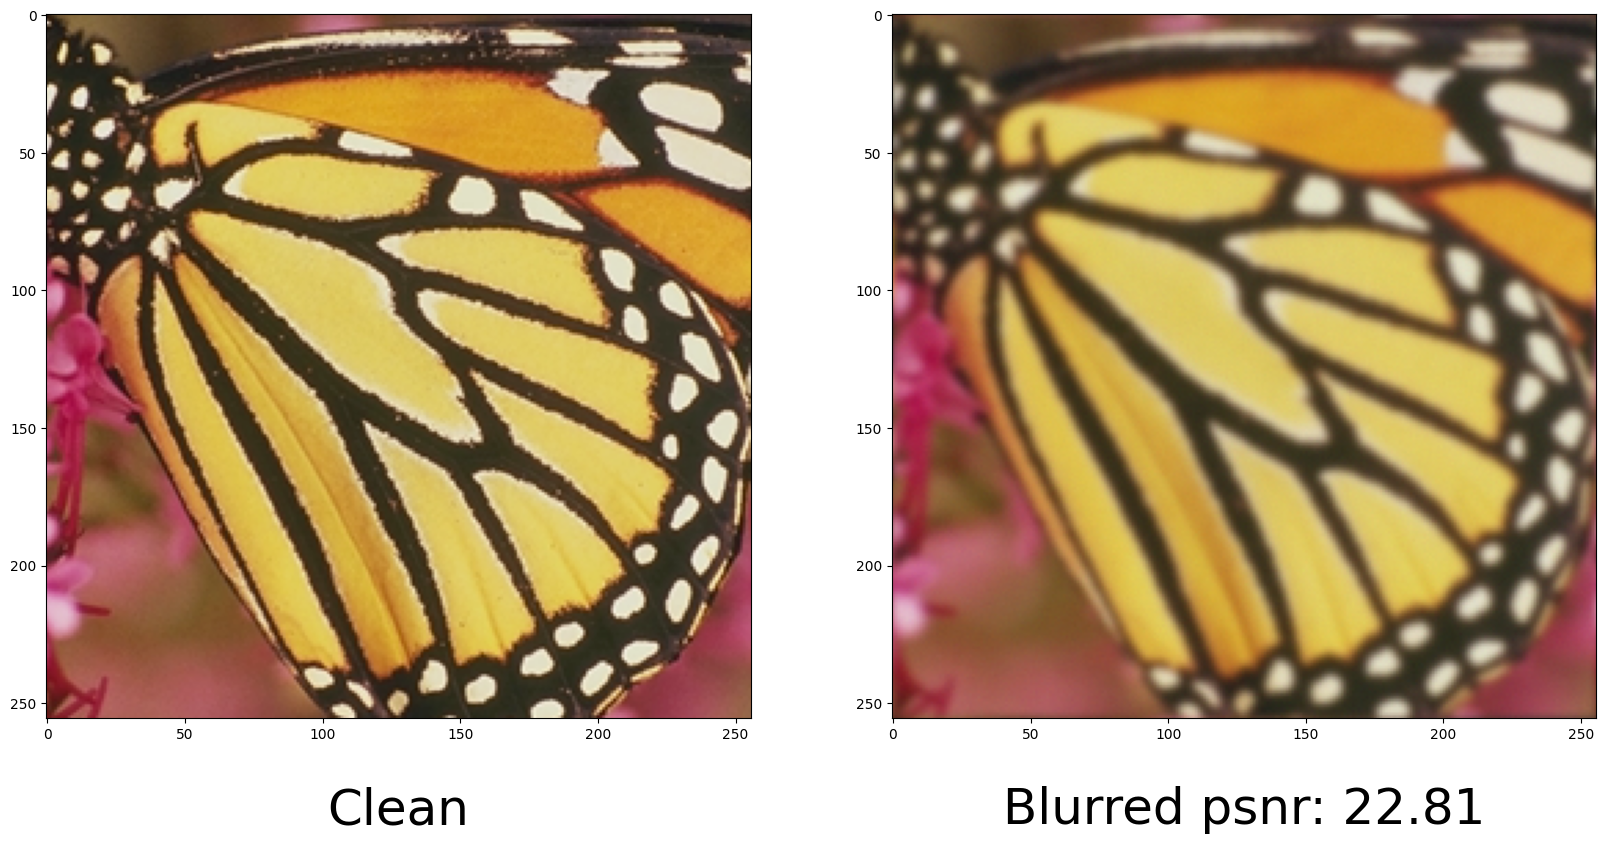

In [15]:
# Get the LR and HR images
data_dict = load_imgs_deblurring('butterfly.png', BLUR_TYPE, NOISE_SIGMA, plot=True)

# THE NETWORK

In [16]:
def get_network_and_input(img_shape, input_depth=32, pad='reflection',
                          upsample_mode='bilinear', use_interpolate=True, align_corners=False,
                          act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4,
                          num_scales=5, downsample_mode='stride', INPUT='noise'):  # 'meshgrid'
    """ Getting the relevant network and network input (based on the image shape and input depth)
        We are using the same default params as in DIP article
        img_shape - the image shape (ch, x, y)
    """
    n_channels = img_shape[0]
    net = skip(input_depth, n_channels,
               num_channels_down=[skip_n33d] * num_scales if isinstance(skip_n33d, int) else skip_n33d,
               num_channels_up=[skip_n33u] * num_scales if isinstance(skip_n33u, int) else skip_n33u,
               num_channels_skip=[skip_n11] * num_scales if isinstance(skip_n11, int) else skip_n11,
               upsample_mode=upsample_mode, use_interpolate=use_interpolate, align_corners=align_corners,
               downsample_mode=downsample_mode, need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun).type(dtype)
    net_input = get_noise(input_depth, INPUT, img_shape[1:]).type(dtype).detach()
    return net, net_input

## Non Local Means denoiser

In [17]:
def non_local_means(noisy_np_img, sigma, fast_mode=True):
    """ get a numpy noisy image
        returns a denoised numpy image using Non-Local-Means
    """
    sigma = sigma / 255.
    h = 0.6 * sigma if fast_mode else 0.8 * sigma
    patch_kw = dict(h=h,                   # Cut-off distance, a higher h results in a smoother image
                    sigma=sigma,           # sigma provided
                    fast_mode=fast_mode,   # If True, a fast version is used. If False, the original version is used.
                    patch_size=5,          # 5x5 patches (Size of patches used for denoising.)
                    patch_distance=6,      # 13x13 search area
                    multichannel=False)
    denoised_img = []
    n_channels = noisy_np_img.shape[0]
    for c in range(n_channels):
        denoise_fast = denoise_nl_means(noisy_np_img[c, :, :], **patch_kw)
        denoised_img += [denoise_fast]
    return np.array(denoised_img, dtype=np.float32)

# Deep Learning Powered by RED, Our Generic Function
## The RED engine with Neural Network
## you may test it with any neural net, and any denoiser

In [18]:
def train_via_admm(net, net_input, denoiser_function, H, y,             # H is the kernel, y is the blurred image
                   clean_img=None, plot_array={}, algorithm_name="",             # clean_img for psnr to be shown
                   gamma=.9, step_size=1000, save_path="",         # scheduler parameters and path to save params
                   admm_iter=30000, LR=0.004,                                          # admm_iter is step_2_iter
                   sigma_f=3, update_iter=10, method='fixed_point',  # method: 'fixed_point' or 'grad' or 'mixed'
                   beta=0.02, mu=0.04, LR_x=None, noise_factor=0.01):  # LR_x needed only if method!=fixed_point
    """ training the network using
        ## Must Params ##
        net                 - the network to be trained
        net_input           - the network input
        denoiser_function   - an external denoiser function, used as black box, this function
                              must get numpy noisy image, and return numpy denoised image
        H                   - the blur kernel
        y                   - the blurred image

        # optional params #
        clean_img           - the original image if exist for psnr compare only, or None (default)
        plot_array          - prints params at the begging of the training and plot images at the required indices
        algorithm_name      - the name that would show up while running, just to know what we are running ;)
        admm_iter           - total number of admm epoch
        LR                  - the lr of the network
        sigma_f             - the sigma to send the denoiser function
        update_iter         - denoised image updated every 'update_iter' iteration
        method              - 'fixed_point' or 'grad' or 'mixed'

        # equation params #
        beta                - regularization parameter (lambda in the article)
        mu                  - ADMM parameter
        LR_x                - learning rate of the parameter x, needed only if method!=fixed point
        # more
        noise_factor       - the amount of noise added to the input of the network
    """
    # get optimizer and loss function:
    mse = torch.nn.MSELoss().type(dtype)  # using MSE loss
    # additional noise added to the input:
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    # x update method:
    if method == 'fixed_point':
        swap_iter = admm_iter + 1
        LR_x = None
    elif method == 'grad':
        swap_iter = -1
    elif method == 'mixed':
        swap_iter = admm_iter // 2
    else:
        assert False, "method can be 'fixed_point' or 'grad' or 'mixed' only "

    # run RED via ADMM, initialize:
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)  # using ADAM opt
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=gamma, step_size=step_size)
    y_torch = np_to_torch(y).type(dtype)
    x = y.copy()
    f_x, u = x.copy(), np.zeros_like(x)
    img_queue = queue.Queue()
    # The denoiser thread that runs in parallel:
    denoiser_thread = Thread(target=lambda q, f, f_args: q.put(f(*f_args)),
                             args=(img_queue, denoiser_function, [x.copy(), sigma_f]))
    denoiser_thread.start()
    # ADMM:
    for i in range(1, 1 + admm_iter):
        # step 1, update network:
        optimizer.zero_grad()
        net_input = net_input_saved + (noise.normal_() * noise_factor)
        out = net(net_input)
        out_np = torch_to_np(out)
        # loss:
        loss_y = mse(H(out), y_torch)
        loss_x = mse(out, np_to_torch(x - u).type(dtype))
        total_loss = loss_y + mu * loss_x
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        # step 2, update x using a denoiser and result from step 1
        if i % update_iter == 0:  # the denoiser work in parallel
            denoiser_thread.join()
            f_x = img_queue.get()
            denoiser_thread = Thread(target=lambda q, f, f_args: q.put(f(*f_args)),
                                     args=(img_queue, denoiser_function, [x.copy(), sigma_f]))
            denoiser_thread.start()

        if i < swap_iter:
            x = 1 / (beta + mu) * (beta * f_x + mu * (out_np + u))
        else:
            x = x - LR_x * (beta * (x - f_x) + mu * (x - out_np - u))
        np.clip(x, 0, 1, out=x)  # making sure that image is in bounds

        # step 3, update u
        u = u + out_np - x

        # show psnrs:
        if clean_img is not None:
            psnr_net = compare_PSNR(clean_img, out_np, on_y=(not GRAY_SCALE), gray_scale=GRAY_SCALE)
            psnr_x_u = compare_PSNR(clean_img, x - u, on_y=(not GRAY_SCALE), gray_scale=GRAY_SCALE)
            print('\r', algorithm_name, '%04d/%04d Loss %f' % (i, admm_iter, total_loss.item()),
                  'psnrs: net: %.2f x-u: %.2f' % (psnr_net, psnr_x_u), end='')
            if plot_array:  # plot graphs only if plotting images, since it time-consuming
                psnr_x_u = compare_PSNR(clean_img, x - u, on_y=(not GRAY_SCALE), gray_scale=GRAY_SCALE)
                psnr_net = compare_PSNR(clean_img, out_np, on_y=(not GRAY_SCALE), gray_scale=GRAY_SCALE)
                if i in plot_array:  # plot images
                    tmp_dict = {'Clean': Data(clean_img),
                                'Blurred': Data(y),
                                'Net': Data(out_np, psnr_net),
                                'x-u': Data(x - u, psnr_x_u),
                                'u': Data((u - np.min(u)) / (np.max(u) - np.min(u)))
                                }
                    plot_dict(tmp_dict)
        else:
            print('\r', algorithm_name, 'iteration %04d/%04d Loss %f' % (i, admm_iter, total_loss.item()), end='')
    # join the thread:
    if denoiser_thread.is_alive():
        denoiser_thread.join()  # joining the thread
    return x - u

## Let's Go:

Exception in thread Thread-4 (<lambda>):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipython-input-2836466415.py", line 57, in <lambda>
  File "/tmp/ipython-input-152310469.py", line 16, in non_local_means
  File "/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py", line 445, in fixed_func
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
TypeError: denoise_nl_means() got an unexpected keyword argument 'multichannel'


 DRED (NLM) 0001/30000 Loss 0.066167 psnrs: net: 13.17 x-u: 19.22

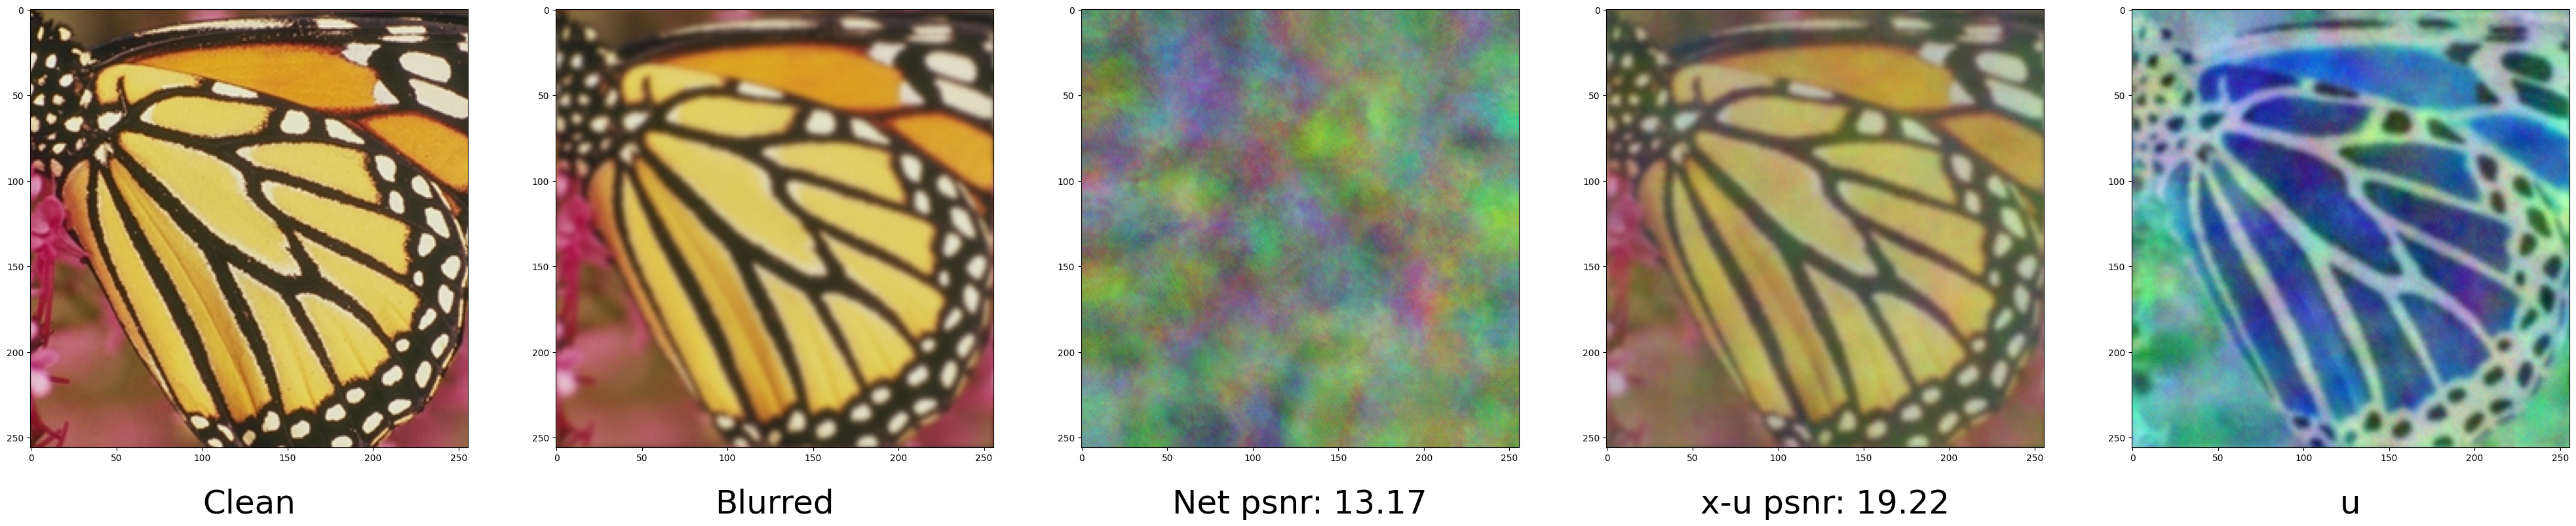

 DRED (NLM) 0009/30000 Loss 0.034450 psnrs: net: 14.11 x-u: 18.00

In [ ]:
def run_and_plot(denoiser, name, plot_checkpoints={}):
    global data_dict
    net, net_input = get_network_and_input(img_shape=data_dict[CORRUPTED].img.shape)
    H = get_h(data_dict[CORRUPTED].img.shape[0], BLUR_TYPE, USE_FOURIER, dtype)
    clean = train_via_admm(net, net_input, denoiser, H, data_dict[CORRUPTED].img,
                           algorithm_name=name, plot_array=plot_checkpoints,
                           clean_img=data_dict[ORIGINAL].img)
    data_dict[name] = Data(clean, compare_PSNR(data_dict[ORIGINAL].img, clean, on_y=(not GRAY_SCALE), gray_scale=GRAY_SCALE))
    plot_dict(data_dict)


plot_checkpoints = {1, 10, 100, 1000, 5000, 10000, 20000}
run_and_plot(non_local_means, DIP_NLM, plot_checkpoints)